In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# This script generates plots based on the bottleneck computation for the entire PDB
### It can be used to visualize LifeSoaks outputs in the same manner when combined to a single .csv file

In [2]:
dataframe = pd.read_csv("data/input_data/WholePDBBottleneckCalculation.csv", delimiter=";")
graphics_folder = "data/plots/"

### Setting visualization options for seaborn

In [3]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,5)},
        style="ticks")

### Remove structures without valid crystal entry

In [4]:
indices_nocrystal = dataframe[dataframe['HasCrystal'] == False].index

print("{} structures are present in the data set".format(len(dataframe)))
print("{} structures have no crystal entry and are therefore removed".format(len(indices_nocrystal)))

dataframe.drop(indices_nocrystal, inplace=True)
print("{} structures remain".format(len(dataframe)))

193448 structures are present in the data set
25571 structures have no crystal entry and are therefore removed
167877 structures remain


### Remove structures without atoms


In [5]:
indices_noatoms = dataframe[dataframe['AtomsPerComplexWithCoordinates'] == 0].index

print("{} structures have no atoms and are therefore removed".format(len(indices_noatoms)))

dataframe.drop(indices_noatoms, inplace=True)
print("{} structures remain".format(len(dataframe)))

53 structures have no atoms and are therefore removed
167824 structures remain


### Remove structures with failed Voronoi computation

In [6]:
indices_failed = dataframe[dataframe['VoronoiComputationSuccessful'] == False].index

print("{} structures failed for unspecified reasons and are discarded".format(len(indices_failed)))

dataframe.drop(indices_failed, inplace=True)
print("{} structures remain".format(len(dataframe)))

416 structures failed for unspecified reasons and are discarded
167408 structures remain


### Pearson correlation heat map
#### Mainly the correlation between Matthews coefficient and the OverallBottleneckRadius is of interest

In [7]:
pearsoncorr = dataframe.corr(method='pearson')

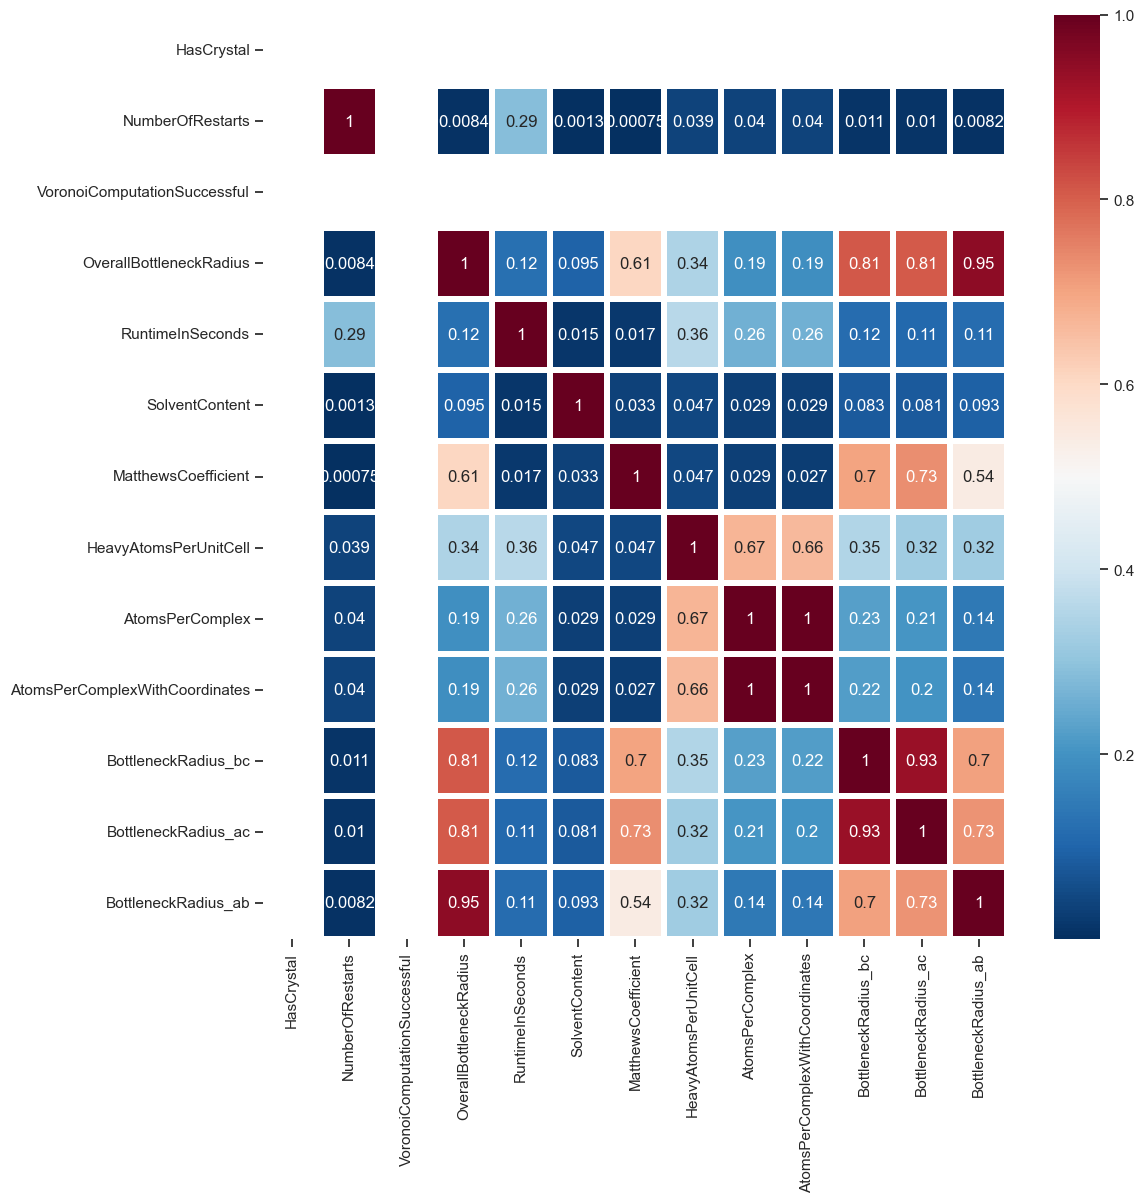

In [8]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=3,
            ax=ax)
plt.savefig(graphics_folder + "heatmap", dpi=500)
plt.show()

### Here we compute a histogram plot of the OverallBottleneckRadius for all successfully computed pdb structures

The mean bottleneck radius is 10.256333470921335 Angstrom
The median bottleneck radius is 7.664045 Angstrom
253 structures have no channel above the threshold
484 structures have a bottleneck radius smaller than 2 Angstrom
14676 structures have a bottleneck radius smaller than 4 Angstrom
371 structures have a bottleneck radius larger than 80 Angstrom
152732 structures have a bottleneck radius larger than 4 Angstrom


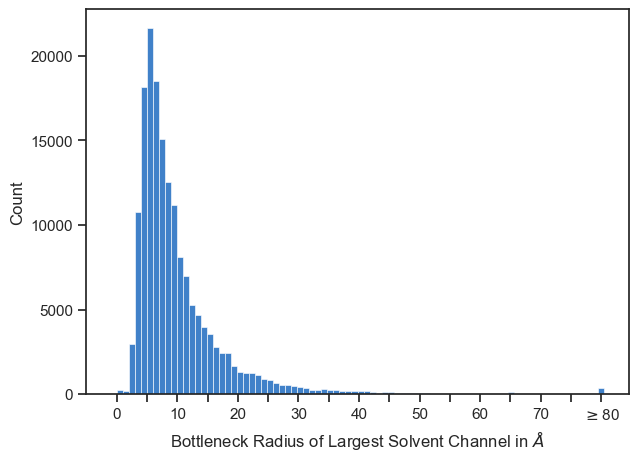

In [9]:
dataframe_copy = dataframe.copy()
max_rad = 80 # A maximum display value for the histogram

print("The mean bottleneck radius is {} Angstrom".format(dataframe_copy["OverallBottleneckRadius"].mean()))
print("The median bottleneck radius is {} Angstrom".format(dataframe_copy["OverallBottleneckRadius"].median()))
print("{} structures have no channel above the threshold".format(dataframe_copy["OverallBottleneckRadius"][dataframe_copy["OverallBottleneckRadius"] < 1.7].count()))
print("{} structures have a bottleneck radius smaller than 2 Angstrom".format(dataframe_copy["OverallBottleneckRadius"][dataframe_copy["OverallBottleneckRadius"] < 2.0].count()))
print("{} structures have a bottleneck radius smaller than 4 Angstrom".format(dataframe_copy["OverallBottleneckRadius"][dataframe_copy["OverallBottleneckRadius"] < 4.0].count()))
print("{} structures have a bottleneck radius larger than 80 Angstrom".format(dataframe_copy["OverallBottleneckRadius"][dataframe_copy["OverallBottleneckRadius"] > 80.0].count()))
print("{} structures have a bottleneck radius larger than 4 Angstrom".format(dataframe_copy["OverallBottleneckRadius"][dataframe_copy["OverallBottleneckRadius"] > 4.0].count()))

#all values exceeding the max_rad are set to max_rad + 0.5. This groups them in the same bin since these outliers
#would hamper the interpretability of the histogram
dataframe_copy['OverallBottleneckRadius'].values[dataframe_copy['OverallBottleneckRadius'] > max_rad] = max_rad + 0.5

p=sns.histplot(data=dataframe_copy,
               x='OverallBottleneckRadius',
               color='#0057b8',
               bins=max_rad + 2)

p.set(xlabel="Bottleneck Radius of Largest Solvent Channel in $\AA$",
      xticks=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80],
      xticklabels=['0','','10','','20','','30','','40','','50','','60','','70','','$\geq$80'])
plt.savefig(graphics_folder + "radius_hist_pdf",dpi=500)
plt.savefig(graphics_folder + "radius_hist_highres",dpi=1200)
plt.show()

## Here we construct correlation plots of solvent content, Matthews coefficient with the bottleneck radii

### Datapreparation set rows with negative solvent content to zero
#### In some extreme cases, the crystal structure is so dense that the approximations of the solvent content calculation lead to negative solvent contents. Since this is not a meaningful value, but the corresponding structures represent interesting examples due to their dense packing, they are not discarded for the plot but set to a solvent content of zero

In [10]:
dataframe_sc_mc = dataframe.copy()
print("{} structures have a negative solvent content which will be set to 0.0".format(len(dataframe_sc_mc[dataframe_sc_mc['SolventContent'] < 0.0])))
dataframe_sc_mc['SolventContent'].values[dataframe_sc_mc['SolventContent'] < 0.0] = 0.0

15 structures have a negative solvent content which will be set to 0.0


### Correlation plot bottleneck radius and Matthews coefficient

In [11]:
max_rad = 80 #extremely high radii are not plotted to improve visualization
max_mc = 8 #as are high Matthews coefficients

indices_exceeding_maxrad = dataframe_sc_mc[dataframe_sc_mc['OverallBottleneckRadius'] > max_rad].index
dataframe_sc_mc.drop(indices_exceeding_maxrad, inplace=True)

dataframe_mc = dataframe_sc_mc.copy()
indices_exceeding_maxmc = dataframe_mc[dataframe_mc['MatthewsCoefficient'] > max_mc].index
dataframe_mc.drop(indices_exceeding_maxmc, inplace=True)

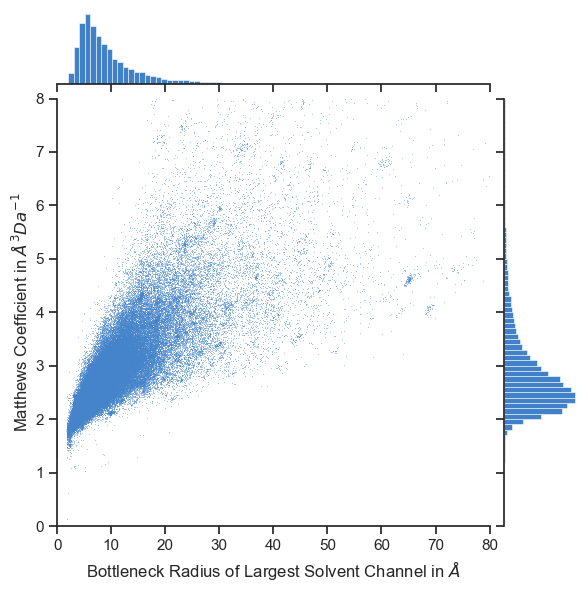

In [12]:
p =sns.jointplot(
      x = 'OverallBottleneckRadius',
      y = 'MatthewsCoefficient',
      data = dataframe_mc,
      kind="scatter",
      xlim={0,80},
      ylim={0,8},
      marginal_kws=dict(bins=80),
      s = 0.25,
      color='#0057b8')
p.set_axis_labels("Bottleneck Radius of Largest Solvent Channel in $\AA$", "Matthews Coefficient in $\AA^3 Da^{-1}$")
plt.savefig(graphics_folder + "scatter_rad_mc_pdf", dpi=500)
plt.savefig(graphics_folder + "scatter_rad_mc_highres", dpi=1200)
plt.show()

### Correlation plot bottleneck radius and solvent content

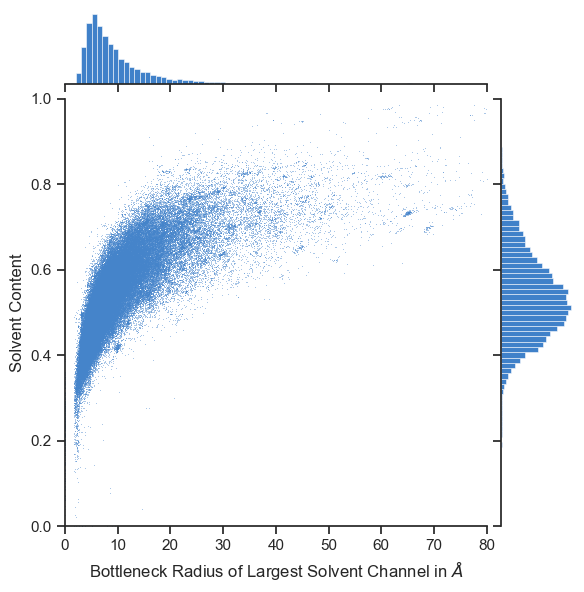

In [13]:
p =sns.jointplot(
      x = 'OverallBottleneckRadius',
      y = 'SolventContent',
      data = dataframe_sc_mc,
      kind="scatter",
      xlim={0,80},
      ylim={0,1},
      marginal_kws=dict(bins=80),
      s = 0.25,
      color='#0057b8')
p.set_axis_labels("Bottleneck Radius of Largest Solvent Channel in $\AA$", "Solvent Content")
plt.savefig(graphics_folder + "scatter_rad_sc_pdf", dpi=500)
plt.savefig(graphics_folder + "scatter_rad_sc_highres", dpi=1200)
plt.show()

### Here we plot the runtime of LifeSoaks as a histogram

The mean runtime is 147.12155333078468 seconds
The median runtime is 61.0 seconds


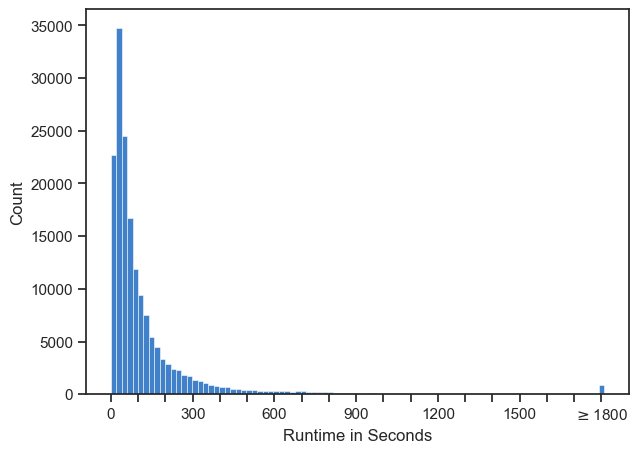

In [14]:
dataframe_t = dataframe.copy()
max_time = 1800

print("The mean runtime is {} seconds".format(dataframe_t["RuntimeInSeconds"].mean()))
print("The median runtime is {} seconds".format(dataframe_t["RuntimeInSeconds"].median()))

#all values exceeding the max_time are set to max_time + 10. This groups them in the same bin since these outliers
#would hamper the interpretability of the histogram

dataframe_t['RuntimeInSeconds'].values[dataframe_t['RuntimeInSeconds'] > max_time] = max_time + 10

p=sns.histplot(data=dataframe_t,
               x='RuntimeInSeconds',
               color='#0057b8',
               bins=int(max_time/20)+1)

p.set(xlabel="Runtime in Seconds",
      xticks=[0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800],
      xticklabels=['0','','','300','','','600','','','900','','','1200','','','1500','','','$\geq$1800'])
plt.savefig(graphics_folder + "runtime_pdf",dpi=500)
plt.savefig(graphics_folder + "runtime_highres",dpi=1200)
plt.show()

### Here we plot the total runtime against the number of atoms in the unit cell

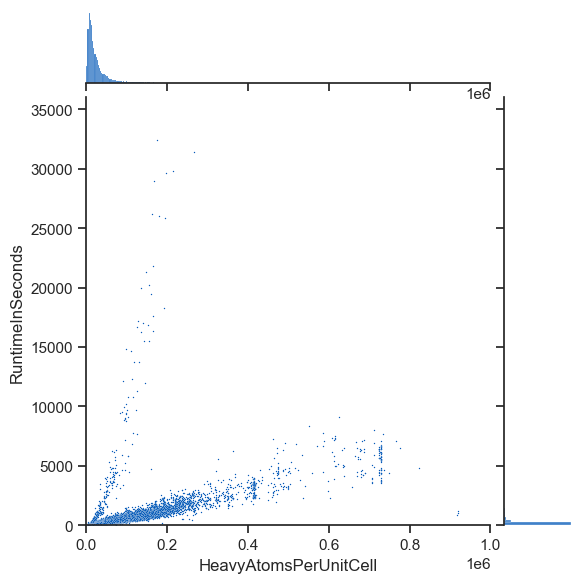

In [15]:
df_time_scatter = dataframe.copy()
maxtime = 36000
maxatom = 1000000

df_time_scatter.drop(df_time_scatter[df_time_scatter["RuntimeInSeconds"] > maxtime].index, inplace=True)
df_time_scatter.drop(df_time_scatter[df_time_scatter["HeavyAtomsPerUnitCell"] > maxatom].index, inplace=True)

p =sns.jointplot(
      x = 'HeavyAtomsPerUnitCell',
      y = 'RuntimeInSeconds',
      data = dataframe,
      kind="scatter",
      xlim={0,maxatom},
      ylim={0,maxtime},
      marginal_kws=dict(bins=800),
      s = 1,
      color='#0057b8')
#p.set_axis_labels("Bottleneck Radius of Largest Solvent Channel in $\AA$", "Solvent Content")
plt.savefig(graphics_folder + "scatter_rad_sc_pdf", dpi=500)
plt.savefig(graphics_folder + "scatter_rad_sc_highres", dpi=1200)
plt.show()